# Data Challenge: Funnel Analysis

# Findings
1. Something happened around 1.5 months ago that reduced the conversion rate
    1. The number of mobile users using the search function has dropped 70%, while desktop users are unaffected.
    1. The number of desktop users selecting an item from the search has dropped 50%, while mobile users are unaffected.
1. Most of the loss in conversions happens at the last two steps, and the last step results in the greatest loss in conversions
1. Sex doesn't seem to be important for conversion

# Conclusions
1. The portion of the funnel that has the lowest conversion rate is the last step: payment confirmation.
1. The search function for mobile users may be bugged.
1. The item selection function for desktop users may be bugged.


In [179]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import numpy as np
import random as rnd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

mpl.rcParams['figure.dpi'] = 150

Import user page-view data

In [180]:
filenames = ['home_page_table.csv','payment_confirmation_table.csv','search_page_table.csv','payment_page_table.csv']

tables = []
for f in filenames:
    tables.append(pd.read_csv(f, dtype={'user_id':'int', 'page':'str'}))

df_page_views = pd.concat(tables)

df_page_views.sort_values(by='user_id').head()

,user_id,page
28468,17,search_page
78382,17,home_page
19852,28,home_page
30643,37,search_page
65331,37,home_page


In [181]:
df_page_views.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142082 entries, 0 to 6029
Data columns (total 2 columns):
user_id    142082 non-null int64
page       142082 non-null object
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


Import user demographic data

In [250]:
dtype = {'user_id': 'int',
         'date':    'str',
         'device':  'category',
         'sex':     'category'}

df_users = pd.read_csv('user_table.csv', dtype=dtype, parse_dates=['date'], index_col='user_id')

df_users.head()

,date,device,sex
user_id,,,
450007,2015-02-28,Desktop,Female
756838,2015-01-13,Desktop,Male
568983,2015-04-09,Desktop,Male
190794,2015-02-18,Desktop,Female
537909,2015-01-15,Desktop,Male


In [251]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 450007 to 438929
Data columns (total 3 columns):
date      90400 non-null datetime64[ns]
device    90400 non-null category
sex       90400 non-null category
dtypes: category(2), datetime64[ns](1)
memory usage: 1.6 MB


From the raw data, we are interested in each user's "final" destination on the site. We can classify each user based on their terminal location. This is an ordinal type with possible values:
- No visit
- Home page
- Search page
- Payment page
- Confirmation page
- Completed purchase

In [252]:
df_page_views.join(df_users, on='user_id', rsuffix='_usr').sample(10)

,user_id,page,page_code,date,device,sex
29659,298116,search_page,1,2015-01-09,Desktop,Female
2128,794897,home_page,0,2015-04-30,Desktop,Male
28580,965606,search_page,1,2015-04-11,Mobile,Male
31637,194154,search_page,1,2015-03-30,Desktop,Male
15122,288365,home_page,0,2015-03-21,Desktop,Female
35468,688623,search_page,1,2015-03-06,Desktop,Male
41617,684771,search_page,1,2015-01-12,Desktop,Male
87170,774206,home_page,0,2015-01-29,Desktop,Female
270,551623,payment_confirmation_page,3,2015-02-08,Mobile,Male
36885,313001,home_page,0,2015-01-17,Desktop,Female


It appears that demographic data is not available for most visitors to the site.

In [188]:
df_page_views.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142082 entries, 0 to 6029
Data columns (total 3 columns):
user_id      142082 non-null int64
page         142082 non-null category
page_code    142082 non-null int8
dtypes: category(1), int64(1), int8(1)
memory usage: 2.4 MB


In [189]:
df_page_views['page'] = pd.Categorical(df_page_views['page'], 
                                       categories=['home_page', 'search_page', 'payment_page', 'payment_confirmation_page'],
                                       ordered=True)

In [190]:
df_page_views['page_code'] = df_page_views['page'].cat.codes

In [191]:
df_page_views.sample(5)

,user_id,page,page_code
13472,409971,search_page,1
32463,331581,home_page,0
4469,684903,search_page,1
24044,936990,home_page,0
21198,114053,home_page,0


In [232]:
highest_page = pd.DataFrame(df_page_views.join(df_users, on='user_id', rsuffix='_usr').groupby(["user_id"])["page_code"].max())

In [234]:
highest_page['page_code_cat'] = highest_page['page_code']
highest_page = pd.get_dummies(data=highest_page, columns=['page_code_cat'], dtype='bool', )
highest_page.rename({'page_code_cat_0': 'visited_site',
          'page_code_cat_1': 'performed_search',
          'page_code_cat_2': 'selected_item',
          'page_code_cat_3': 'completed_purchase'}, 
         inplace=True, axis='columns')
highest_page.head()

,page_code,visited_site,performed_search,selected_item,completed_purchase
user_id,,,,,
17,1,False,True,False,False
28,0,True,False,False,False
37,1,False,True,False,False
38,2,False,False,True,False
55,0,True,False,False,False


In [235]:
highest_page.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 17 to 999979
Data columns (total 5 columns):
page_code             90400 non-null int8
visited_site          90400 non-null bool
performed_search      90400 non-null bool
selected_item         90400 non-null bool
completed_purchase    90400 non-null bool
dtypes: bool(4), int8(1)
memory usage: 1.1 MB


In [240]:
{'search conversion' : highest_page['performed_search'].sum() / highest_page['visited_site'].sum(),
              'item selection conversion' : highest_page['selected_item'].sum() / highest_page['performed_search'].sum(),
              'payment conversion' : highest_page['completed_purchase'].sum() / highest_page['selected_item'].sum()}

{'search conversion': 0.8665929203539823,
 'item selection conversion': 0.14240490171049272,
 'payment conversion': 0.08103262818214414}

In [246]:
conversion_type = ['search', 'item selection', 'payment']
conversion_pct = [highest_page['performed_search'].sum()   / highest_page['visited_site'].sum(),
                  highest_page['selected_item'].sum()      / highest_page['performed_search'].sum(),
                  highest_page['completed_purchase'].sum() / highest_page['selected_item'].sum()]

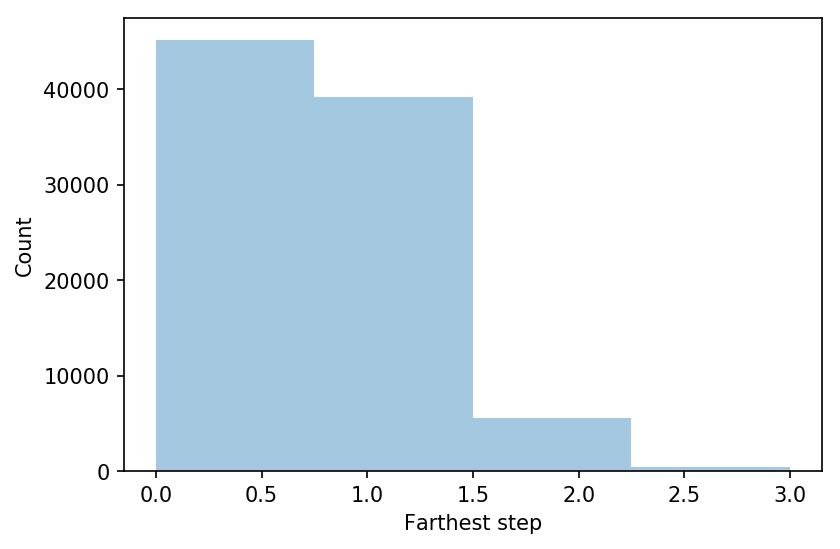

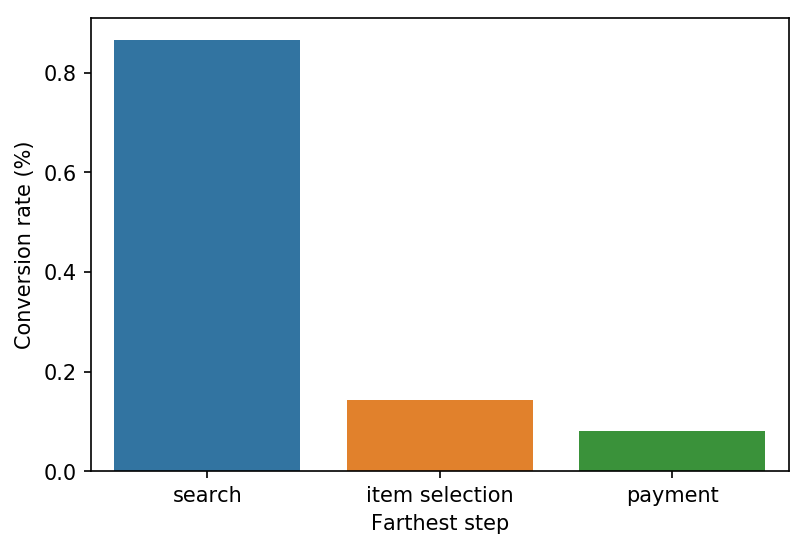

In [255]:
sns.distplot(highest_page['page_code'], kde=False, bins=4)
plt.xlabel('Farthest step')
#plt.xticks(['home_page', 'search_page', 'payment_page', 'payment_confirmation_page'])
plt.ylabel('Count')
plt.show()

sns.barplot(x=conversion_type, y=conversion_pct)
plt.xlabel('Farthest step')
plt.ylabel('Conversion rate (%)')
plt.show()

Here we see that most people who visit the site perform a search, many of those people do not select an item, and many people who select an item never complete the purchase. We should focus on the last two steps of the funnel.

In [249]:
highest_page.head()

,page_code,visited_site,performed_search,selected_item,completed_purchase
user_id,,,,,
17,1,False,True,False,False
28,0,True,False,False,False
37,1,False,True,False,False
38,2,False,False,True,False
55,0,True,False,False,False


In [257]:
df_users = df_users.join(highest_page)

In [258]:
df_users.head()

,date,device,sex,page_code,visited_site,performed_search,selected_item,completed_purchase
user_id,,,,,,,,
450007,2015-02-28,Desktop,Female,0,True,False,False,False
756838,2015-01-13,Desktop,Male,0,True,False,False,False
568983,2015-04-09,Desktop,Male,1,False,True,False,False
190794,2015-02-18,Desktop,Female,1,False,True,False,False
537909,2015-01-15,Desktop,Male,0,True,False,False,False


/home/pavel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


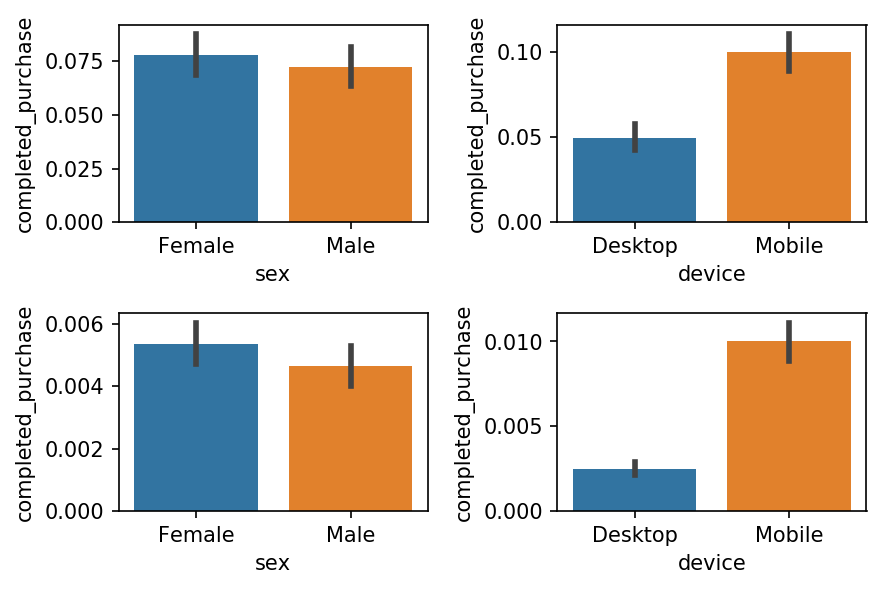

In [337]:
plt.subplot(2,2,1)
sns.barplot(data=df_users[df_users['page_code']>=2], x='sex', y='completed_purchase')
plt.subplot(2,2,2)
sns.barplot(data=df_users[df_users['page_code']>=2], x='device', y='completed_purchase')
plt.subplot(2,2,3)
sns.barplot(data=df_users, x='sex', y='completed_purchase')
plt.subplot(2,2,4)
sns.barplot(data=df_users, x='device', y='completed_purchase')
plt.tight_layout()

Ignoring missing values, we see almost double the conversion for mobile customers relative to desktop customers. Looking at the data over time, we see a decrease in the final conversion rate for both mobile and desktop customers.

Text(0,0.5,'Count')

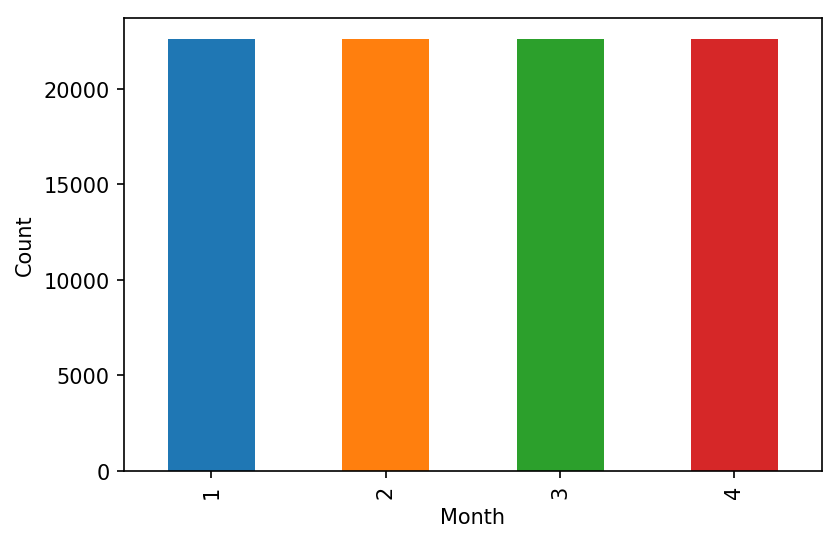

In [277]:
df_users.groupby(df_users["date"].dt.month)['date'].count().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('Count')

From this plot we can see that conversion rates have fallen for searches and item selection but not for payment confirmation. Since the total number of users visiting the site has not changed, this suggests the problem is related to the search results.

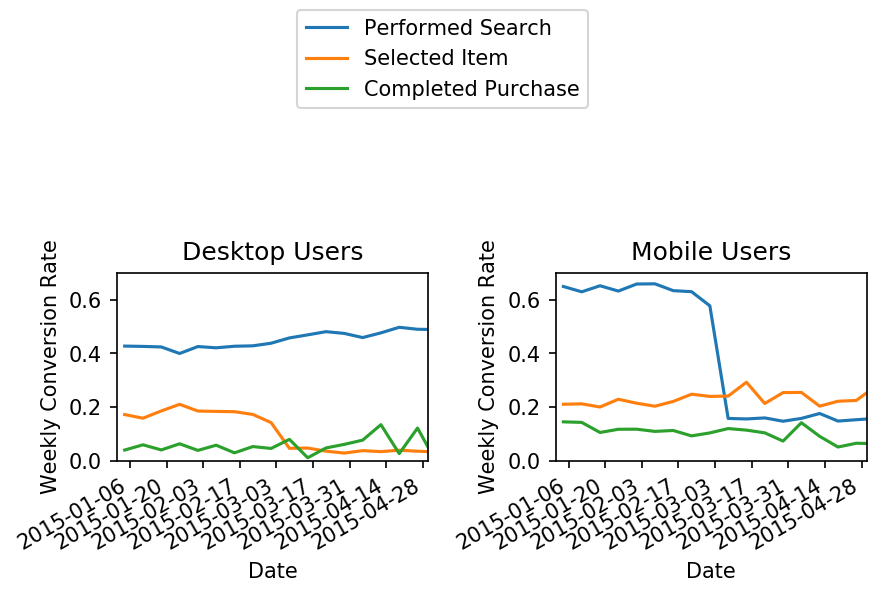

In [340]:
fig = plt.figure()
plt.subplot(2,2,3)
df = df_users[df_users.device == 'Desktop']

df = df.set_index(df['date'])
df = df.sort_index()

df_mean1 = df[['performed_search']].resample('1w').mean()
df_mean2 = df[['selected_item']].resample('1w').mean()
df_mean3 = df[['completed_purchase']].resample('1w').mean()
df_mean = df_mean1.join(df_mean2).join(df_mean3)
df_mean['completed_purchase'] = df_mean['completed_purchase'] / df_mean['selected_item']
df_mean['selected_item'] = df_mean['selected_item'] / df_mean['performed_search']
df_mean['date'] = df_mean.index

ax = sns.lineplot(data=df_mean, x='date', y='performed_search', legend="full")
ax = sns.lineplot(data=df_mean, x='date', y='selected_item', legend="full")
ax = sns.lineplot(data=df_mean, x='date', y='completed_purchase', legend="full")
    
# Make plot look nice
plt.xlim([np.min(df_users.date), np.max(df_users.date)])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Weekly Conversion Rate')
plt.ylim([0,0.7])
plt.title('Desktop Users')

plt.subplot(2,2,4)
df = df_users[df_users.device == 'Mobile']

df = df.set_index(df['date'])
df = df.sort_index()

df_mean1 = df[['performed_search']].resample('1w').mean()
df_mean2 = df[['selected_item']].resample('1w').mean()
df_mean3 = df[['completed_purchase']].resample('1w').mean()
df_mean = df_mean1.join(df_mean2).join(df_mean3)
df_mean['completed_purchase'] = df_mean['completed_purchase'] / df_mean['selected_item']
df_mean['selected_item'] = df_mean['selected_item'] / df_mean['performed_search']
df_mean['date'] = df_mean.index

ax = sns.lineplot(data=df_mean, x='date', y='performed_search', legend="full")
ax = sns.lineplot(data=df_mean, x='date', y='selected_item', legend="full")
ax = sns.lineplot(data=df_mean, x='date', y='completed_purchase', legend="full")
    
# Make plot look nice
plt.xlim([np.min(df_users.date), np.max(df_users.date)])
fig.autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Weekly Conversion Rate')
plt.ylim([0,0.7])
fig.legend(labels=['Performed Search', 'Selected Item', 'Completed Purchase'], loc="upper center")
plt.title('Mobile Users')

plt.tight_layout()

# Conclusions
1. The portion of the funnel that has the lowest conversion rate is the last step: payment confirmation.
1. The search function for mobile users may be bugged.
1. The item selection function for desktop users may be bugged.